### Basic Settings

In [1]:
import logging
import random

from nlp_practice.case.translation.data.dataloader import PairDataLoader
from nlp_practice.model.decoder import AttentionDecoderRNN, DecoderRNN
from nlp_practice.model.encoder import EncoderRNN
from nlp_practice.case.translation.training.trainer import Trainer
from nlp_practice.case.translation.Inference.predictor import Predictor
from nlp_practice.case.translation.data.preprocessor import Preprocessor
from nlp_practice.case.translation.evalution.evaluator import Evaluator

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger()

### Parameters

In [2]:
batch_size = 256
hidden_size = 128
dropout_rate = 0.1
num_epochs = 500
training_rate = 0.8
learning_rate = 0.001
device = "cpu"
data_base_path = "../data"
first_language = "eng"
second_language = "fra" 
normal_checkpoint = "normal_seq2seq.pt"
attention_checkpoint = "attention_seq2seq.pt"

### Data Preprocessing

In [3]:
input_language, output_language, pairs = Preprocessor(
    base_path=data_base_path,
    first_language=first_language,
    second_language=second_language,
    does_reverse=True,
).process()

### Model Setup

In [4]:
encoder = EncoderRNN(
    input_size=input_language.num_words,
    hidden_size=hidden_size,
    dropout_rate=dropout_rate,
).to(device)


normal_decoder = DecoderRNN(
    hidden_size=hidden_size,
    output_size=output_language.num_words,
    dropout_rate=dropout_rate,
    device=device,
).to(device)

attention_decoder = AttentionDecoderRNN(
    hidden_size=hidden_size,
    output_size=output_language.num_words,
    dropout_rate=dropout_rate,
    device=device,
).to(device)


### Training Process

In [5]:
train_dataloader = PairDataLoader(
    pairs=pairs,
    input_language=input_language,
    output_language=output_language,
    training_rate=training_rate,
    batch_size=batch_size,
    device=device,
).train_dataloader

In [6]:
normal_trainer = Trainer(
    train_dataloader=train_dataloader,
    encoder=encoder,
    decoder=normal_decoder,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
)
normal_loss = normal_trainer.train()

100%|██████████| 500/500 [1:45:46<00:00, 12.69s/it]   


In [7]:
attention_trainer = Trainer(
    train_dataloader=train_dataloader,
    encoder=encoder,
    decoder=attention_decoder,
    num_epochs=num_epochs,
    learning_rate=learning_rate,
)
attention_loss = attention_trainer.train()

100%|██████████| 500/500 [5:42:09<00:00, 41.06s/it]    


### Evaluation
This section presents a comprehensive evaluation of the training results, examining both inference outputs and relevant metrics, including their associated losses.

#### I. Loss Comparison
Explore the cross-entropy losses of both models across different epochs for a thorough understanding of their training performance.

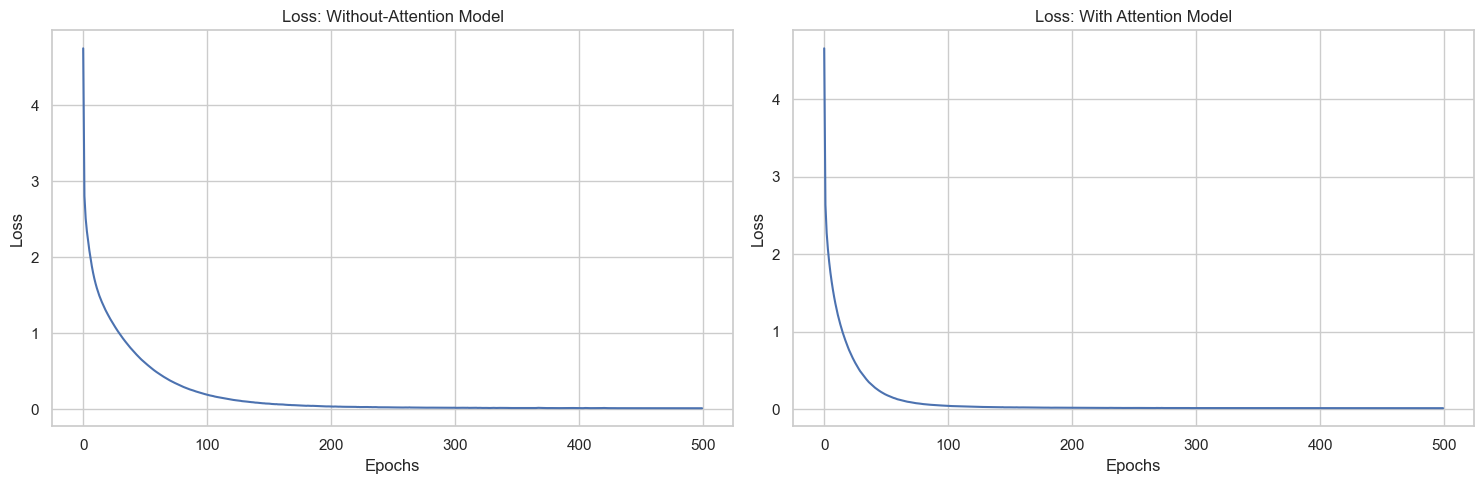

In [13]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(normal_loss, ax=axes[0])
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss: Without-Attention Model')

sns.lineplot(attention_loss, ax=axes[1])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss: With Attention Model')

plt.tight_layout()
plt.show()

#### II. Inference
Utilizing the trained encoder and decoder models, we can proficiently translate input language sequences. To illustrate the translation quality, we showcase the capabilities of these models by randomly selecting three sentences for evaluation.


In [9]:
normal_predictor = Predictor(encoder, normal_decoder, input_language, output_language)
attention_predictor = Predictor(encoder, attention_decoder, input_language, output_language)

In [18]:
input_sentence, answer = random.choice(pairs)
LOGGER.info(f"Translate {input_sentence!r}")
LOGGER.info(f"True: {answer!r}")
LOGGER.info(f"Result without attention: {' '.join(normal_predictor.translate(input_sentence))!r}")
LOGGER.info(f"Result with attention: {' '.join(attention_predictor.translate(input_sentence))!r}")

INFO:root:Translate 'je suis en train de me peser'
INFO:root:True: 'i am weighing myself'
INFO:root:Result without attention: 'i am bound to him by a close friendship'
INFO:root:Result with attention: 'i am weighing myself'


In [17]:
input_sentence, answer = random.choice(pairs)
LOGGER.info(f"Translate {input_sentence!r}")
LOGGER.info(f"True: {answer!r}")
LOGGER.info(f"Result without attention: {' '.join(normal_predictor.translate(input_sentence))!r}")
LOGGER.info(f"Result with attention: {' '.join(attention_predictor.translate(input_sentence))!r}")

INFO:root:Translate 'vous etes bon cuisinier n est ce pas ?'
INFO:root:True: 'you are a good cook aren t you ?'
INFO:root:Result without attention: 'you re kind of cute when you re mad'
INFO:root:Result with attention: 'you are a good cook aren t you ?'


In [19]:
input_sentence, answer = random.choice(pairs)
LOGGER.info(f"Translate {input_sentence!r}")
LOGGER.info(f"True: {answer!r}")
LOGGER.info(f"Result without attention: {' '.join(normal_predictor.translate(input_sentence))!r}")
LOGGER.info(f"Result with attention: {' '.join(attention_predictor.translate(input_sentence))!r}")

INFO:root:Translate 'je suis plus petite que vous'
INFO:root:True: 'i m shorter than you'
INFO:root:Result without attention: 'i m glad you re ok now'
INFO:root:Result with attention: 'i m shorter than you'


#### III. Metric Evaluation using the Test Dataset
In assessing the performance of our models, we employ several key metrics, each offering unique insights into their capabilities.

- **Accuracy:** This metric gauges the exact match between the model's predictions and the actual results, providing a straightforward measure of correctness.

- **[ROUGE-1](https://en.wikipedia.org/wiki/ROUGE_(metric)):** Focused on unigrams, ROUGE-1 evaluates the alignment between the model's output and the reference text at the level of individual words. Precision, recall, and the F1 score within the ROUGE-1 framework offer distinct perspectives on the model's effectiveness in capturing relevant information from the reference, particularly at the granularity of unigrams.

In [11]:
test_dataloader = PairDataLoader(
    pairs=pairs,
    input_language=input_language,
    output_language=output_language,
    training_rate=training_rate,
    batch_size=batch_size,
    device=device,
).test_dataloader

normal_evaluator = Evaluator(test_dataloader, normal_predictor)
attention_evaluator = Evaluator(test_dataloader, attention_predictor)

result_pdf = pd.DataFrame.from_dict(
    {
        "model": ["Without-Attention", "With-Attention"],
        "accuracy": [normal_evaluator.accuracy, attention_evaluator.accuracy],
        "rouge-1-precision": [normal_evaluator.rouge1_precision, attention_evaluator.rouge1_precision],
        "rouge-1-recall": [normal_evaluator.rouge1_recall, attention_evaluator.rouge1_recall],
        "rouge-1-f1": [normal_evaluator.rouge1_f1, attention_evaluator.rouge1_f1],
    }
)
result_melted = pd.melt(result_pdf, id_vars="model", var_name="metric", value_name="value")

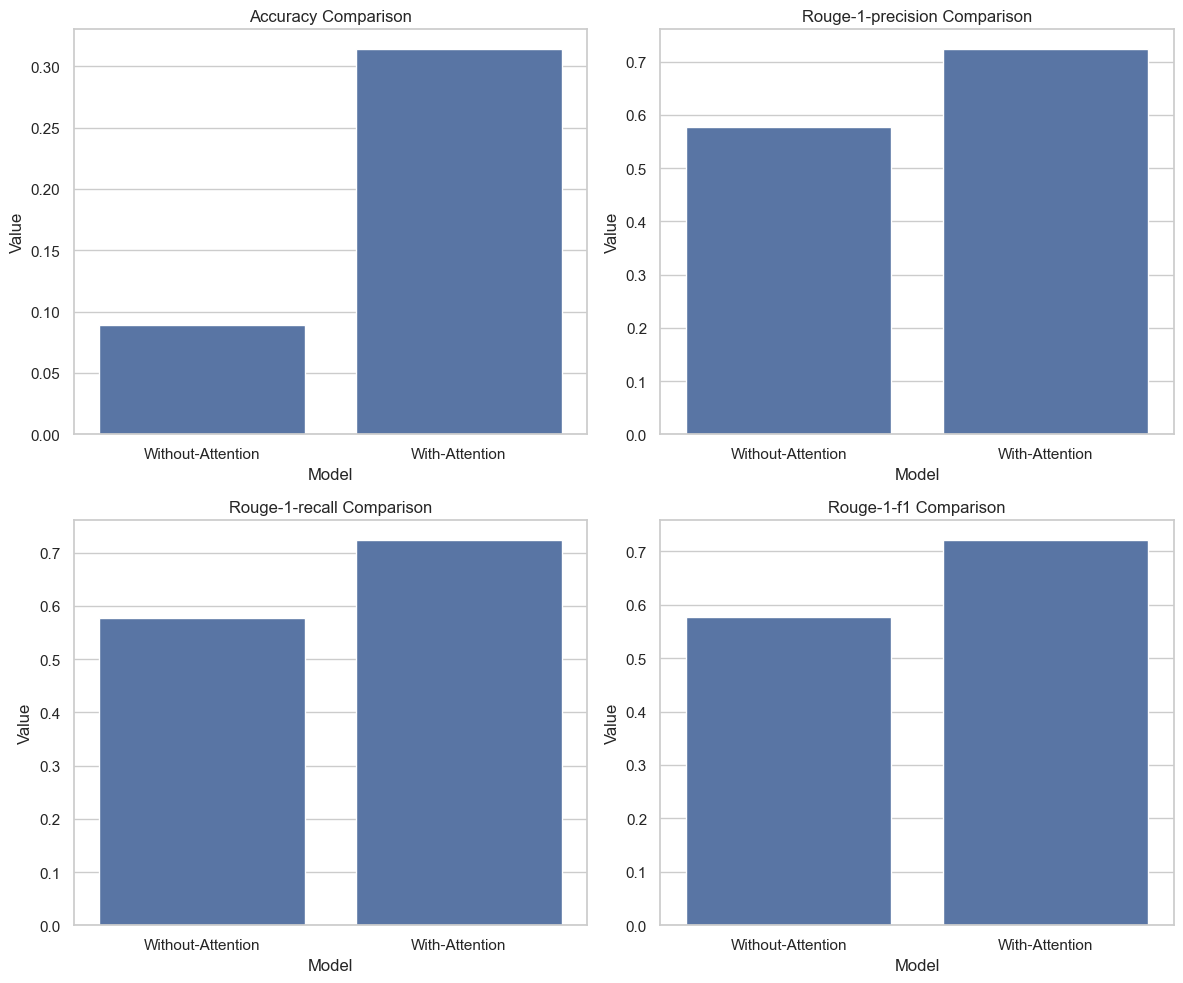

In [12]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

metrics = result_pdf.columns[1:]
for metric, ax in zip(metrics, axes.flatten()):
    sns.barplot(x="model", y="value", data=result_melted[result_melted["metric"] == metric], ax=ax)
    ax.set(title=f"{metric.capitalize()} Comparison", xlabel="Model", ylabel="Value")

plt.tight_layout()
plt.show()

## Conclusion
- The losses of both models appear similar and converge, indicating comparable training dynamics.

- Inference results reveal a crucial distinction: the "With Attention" decoder effectively translates the true results, while the "Without Attention" decoder falls short in this regard.
- Examining the evaluation metrics provides deeper insights. The "With Attention" decoder consistently outperforms the "Without Attention" decoder across all metrics—ROUGE-1 Precision, ROUGE-1 Recall, ROUGE-1 F1, and accuracy. This consistent superiority suggests that the attention mechanism significantly contributes to enhanced accuracy and improved text generation quality. The emphasis on individual words (ROUGE-1) reinforces the importance of attention in capturing precise details and nuances during translation.